In [6]:
import numpy as np
import torchvision
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet50
from torchcam.methods import SmoothGradCAMpp
from PIL import Image
import requests

model = resnet50(pretrained=True).eval()
cam_extractor = SmoothGradCAMpp(model)
# Get your input

to_tensor = torchvision.transforms.ToTensor()

image_url = "https://ggsc.s3.amazonaws.com/images/made/images/uploads/The_Science-Backed_Benefits_of_Being_a_Dog_Owner_300_200_int_c1-1x.jpg"
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = to_tensor(image)

# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

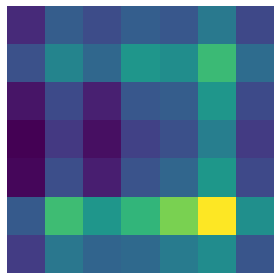

In [7]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

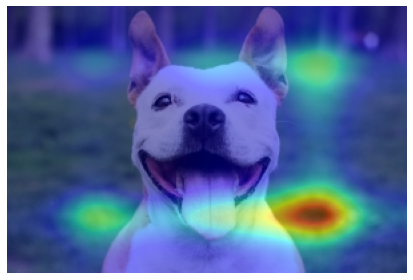

In [8]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()